<a href="https://colab.research.google.com/github/sahil-bhatia-iitbhu/deep_understanding_of_deep_learning/blob/main/12_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GPU

Utility:
1. Custom designed for matrix multiplications
2. Designed to be parallel
3. Thousands of cores
4. Break a big task into tiny pieces
5. Requires additional softwares

Why to use GPUs:
1. Most of DL is predominantly simple but tedious matrix multiplication
2. Outsource this specific task to someone who holds expertise to do it faster

When to use GPUs:
1. When model is large or complex, and most of explorations are done with experimentations left on final output efficiency and production inference
2. Speed gains are minimal for small models

In [1]:
# import libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time

In [2]:
## Note: To run models on a GPU you must select from the menu:
#   -> Runtime
#     -> Change runtime type
#       -> Hardware accelerator
#         -> GPU

In [3]:
# use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
net = nn.Sequential(
    nn.Linear(20,100),
    nn.ReLU(),
    nn.Linear(100,500),
    nn.ReLU(),
    nn.Linear(500,30),
    nn.ReLU(),
    nn.Linear(30,2)
      )

In [5]:
# just some random fluff
data   = torch.randn((1000,20)) # samples X features
labels = torch.randint(low=0,high=2,size=(1,1000))

In [6]:
# model
net.to(device)

# data
data   = data.to(device)
labels = labels.to(device)

In [7]:
data

tensor([[ 0.1520, -1.1301, -0.2300,  ...,  0.5224,  0.0791,  0.0699],
        [-0.9162, -0.5484,  0.8379,  ...,  0.5707, -0.2551, -1.6570],
        [ 0.0889, -0.4710,  2.9905,  ...,  1.6501, -1.5934, -2.1069],
        ...,
        [-1.5049,  1.4054, -0.3234,  ...,  0.0924,  1.1875, -0.5557],
        [-0.3271, -0.0475,  0.7805,  ..., -0.1945,  0.9775,  1.0922],
        [-3.1888, -0.3578, -0.9060,  ..., -1.1456,  0.7996,  0.1975]],
       device='cuda:0')

In [8]:
# you can also create data directly on the GPU
dataG = torch.randn((1000,20),device=device)
dataC = torch.randn((1000,20),device='cpu')

print(data.device)
print(dataG.device)
print(dataC.device)

cuda:0
cuda:0
cpu


In [9]:
output = net(data)


output.device

device(type='cuda', index=0)

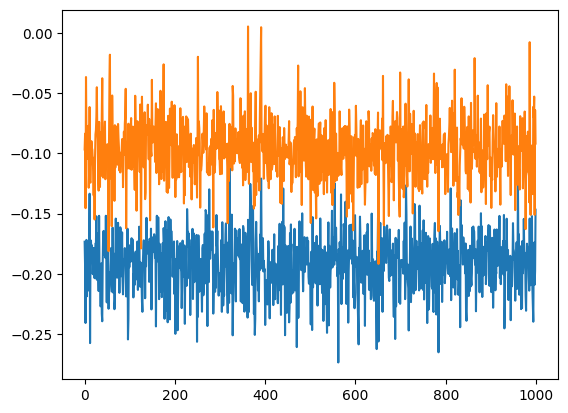

In [11]:
# try to plot the data
# plt.plot(output.detach());
# TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

plt.plot(output.detach().cpu());

**Experiment on Computation Time**

In [12]:
# start the clock
starttime = time.process_time()

# move, run, retrieve
device = 'cuda:0'
net.to(device)
data   = data.to(device)
labels = labels.to(device)
output = net(data).detach().cpu()

# stop the clock
GPUtime = 1000*(time.process_time() - starttime)

In [13]:
# start the clock
starttime = time.process_time()

# move, run, retrieve
device = 'cpu'
net.to(device)
data   = data.to(device)
labels = labels.to(device)
output = net(data).detach().cpu()

# stop the clock
CPUtime = 1000*(time.process_time() - starttime)

In [14]:
# time in ms
[CPUtime,GPUtime]

[8.835752000000419, 2.6121059999999474]

**but maybe "sending" it to the CPU takes too much overhead?**

In [16]:
# recreate network and data
net  = nn.Sequential(nn.Linear(20,100),nn.ReLU(),nn.Linear(100,500),nn.ReLU(),nn.Linear(500,30),nn.ReLU(),nn.Linear(30,2))
data = torch.randn((1000,20))

# rerun the experiment
starttime = time.process_time()
output    = net(data).detach()
CPUtime2  = 1000*(time.process_time() - starttime)

# report the results
[CPUtime2,GPUtime]

[3.9629799999998383, 2.6121059999999474]

Here the difference is minimalist when everything is done on CPU vs GPU.

But think about the difference when complex computation comes in. Such small differences across all computations pulls up to big differences in time.

### Full model on GPU

In [17]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [18]:
# use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [19]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

In [20]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [21]:
# create a class for the model
def createTheMNISTNet(nUnits,nLayers):

  class mnistNet(nn.Module):
    def __init__(self,nUnits,nLayers):
      super().__init__()

      # create dictionary to store the layers
      self.layers = nn.ModuleDict()
      self.nLayers = nLayers

      ### input layer
      self.layers['input'] = nn.Linear(784,nUnits)

      ### hidden layers
      for i in range(nLayers):
        self.layers[f'hidden{i}'] = nn.Linear(nUnits,nUnits)

      ### output layer
      self.layers['output'] = nn.Linear(nUnits,10)



    # forward pass
    def forward(self,x):
      # input layer
      x = self.layers['input'](x)

      # hidden layers
      for i in range(self.nLayers):
        x = F.relu( self.layers[f'hidden{i}'](x) )

      # return output layer
      x = self.layers['output'](x)
      return F.log_softmax(x,dim=1)

  # create the model instance
  net = mnistNet(nUnits,nLayers)

  # loss function
  lossfun = nn.NLLLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [22]:
# Generate an instance of the model and confirm that it returns the expected network.
nUnitsPerLayer = 12
nLayers = 4
net = createTheMNISTNet(nUnitsPerLayer,nLayers)
net

(mnistNet(
   (layers): ModuleDict(
     (input): Linear(in_features=784, out_features=12, bias=True)
     (hidden0): Linear(in_features=12, out_features=12, bias=True)
     (hidden1): Linear(in_features=12, out_features=12, bias=True)
     (hidden2): Linear(in_features=12, out_features=12, bias=True)
     (hidden3): Linear(in_features=12, out_features=12, bias=True)
     (output): Linear(in_features=12, out_features=10, bias=True)
   )
 ),
 NLLLoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

In [23]:
# a function that trains the model

def function2trainTheModel(nUnits,nLayers):

  # number of epochs
  numepochs = 60

  # create a new model
  net,lossfun,optimizer = createTheMNISTNet(nUnits,nLayers)

  # New!
  net.to(device)

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # New!
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # New! bring outputs back
      yHat = yHat.cpu()
      y = y.cpu()

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader

    # New!
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # New! bring outputs back
    yHat = yHat.cpu()
    y = y.cpu()

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

In [24]:
# test the model once to make sure it works
trainAcc,testAcc,losses,net = function2trainTheModel(65,2)

In [25]:
### run the experiment!
#  CPU took 30 mins
#  GPU takes 13 mins

# define the model parameters
numlayers = range(1,4)           # number of hidden layers
numunits  = np.arange(50,251,50) # units per hidden layer

# initialize output matrices
accuracies  = np.zeros((2,len(numunits),len(numlayers)))

# start the experiment!
for unitidx in range(len(numunits)):
  for layeridx in range(len(numlayers)):

    # create and train a fresh model
    trainAcc,testAcc,losses,net = function2trainTheModel(numunits[unitidx],numlayers[layeridx])

    # store the results (average of final 5 epochs)
    accuracies[0,unitidx,layeridx] = np.mean(trainAcc[-5:])
    accuracies[1,unitidx,layeridx] = np.mean(testAcc[-5:])

    # print a friendly status message
    print(f'Finished units {unitidx+1}/{len(numunits)} and layers {layeridx+1}/{len(numlayers)}')

Finished units 1/5 and layers 1/3
Finished units 1/5 and layers 2/3
Finished units 1/5 and layers 3/3
Finished units 2/5 and layers 1/3
Finished units 2/5 and layers 2/3
Finished units 2/5 and layers 3/3
Finished units 3/5 and layers 1/3
Finished units 3/5 and layers 2/3
Finished units 3/5 and layers 3/3
Finished units 4/5 and layers 1/3
Finished units 4/5 and layers 2/3
Finished units 4/5 and layers 3/3
Finished units 5/5 and layers 1/3
Finished units 5/5 and layers 2/3
Finished units 5/5 and layers 3/3


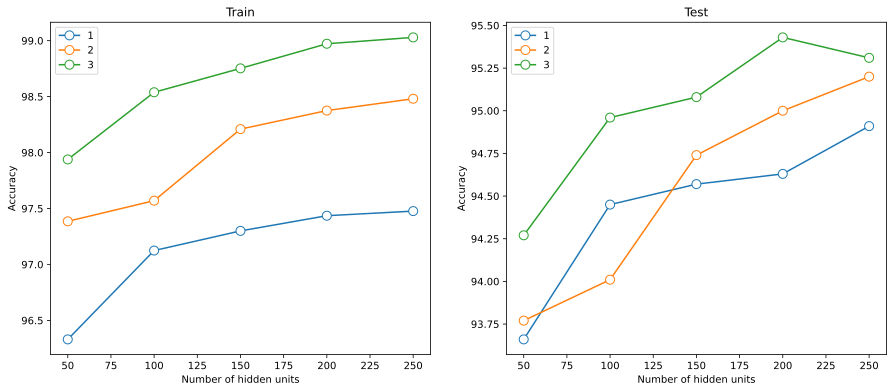

In [26]:
# show accuracy as a function of model depth
fig,ax = plt.subplots(1,2,figsize=(15,6))

ax[0].plot(numunits,accuracies[0,:,:],'o-',markerfacecolor='w',markersize=9)
ax[1].plot(numunits,accuracies[1,:,:],'o-',markerfacecolor='w',markersize=9)

for i in range(2):
  ax[i].legend(numlayers)
  ax[i].set_ylabel('Accuracy')
  ax[i].set_xlabel('Number of hidden units')
  ax[i].set_title([ 'Train' if i==0 else 'Test' ][0])

plt.show()